In [ ]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')
with zipfile.ZipFile('/content/drive/MyDrive/Dataset_Bersih.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import joblib

# Path ke direktori dataset
dataset_dir = '/content/Dataset Bersih'

# Memuat dataset
full_dataset = image_dataset_from_directory(dataset_dir,
                                            labels='inferred',
                                            label_mode='int',
                                            class_names=['mel', 'bcc', 'norm'],
                                            image_size=(224, 224),
                                            batch_size=32,
                                            shuffle=True)


Found 1725 files belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

# Menambahkan GlobalAveragePooling2D layer untuk mendapatkan vektor fitur
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])

model.summary()

def extract_features(dataset):
    features = []
    labels = []
    for images, lbls in dataset:
        preprocessed_images = preprocess_input(images)
        feats = model.predict(preprocessed_images)
        features.append(feats)
        labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

full_features, full_labels = extract_features(full_dataset)


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 14714688 (56.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [==============================] - 12s 12s/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
import pandas as pd  # Impor pandas
# # Menampilkan hasil ekstraksi fitur menggunakan DataFrame
# feature_names = [f"feature_{i}" for i in range(full_features.shape[1])]
# df = pd.DataFrame(data=full_features, columns=feature_names)
# df['label'] = full_labels

# print(df)

# Feature names for DataFrame
feature_names = [f"feature_{i}" for i in range(full_features.shape[1])]

# Creating DataFrame from extracted features and labels
df = pd.DataFrame(data=full_features, columns=feature_names)
df['label'] = full_labels

# Function to map label integer to class name
def map_label(label):
    class_names = ['mel', 'bcc', 'norm']
    return class_names[label]

# Applying map_label function to convert labels to class names
df['label'] = df['label'].apply(map_label)

# Displaying DataFrame with better format
pd.set_option('display.max_columns', 10)  # Show all columns
pd.set_option('display.max_rows', 10)  # Limit the number of rows displayed
pd.set_option('display.float_format', lambda x: '%.4f' % x)  # Format float numbers

# Showing the first few rows of the DataFrame
print(df.head())

# Optionally, save the DataFrame to a CSV file for further analysis
df.to_csv('/content/extracted_features_Mobilenet.csv', index=False)

   feature_0  feature_1  feature_2  feature_3  feature_4  ...  feature_508  \
0     0.0869     0.0000     0.1808     0.0134     0.4758  ...       0.0000   
1     0.0827     0.0000     0.0000     0.0000     0.1076  ...       0.0000   
2     0.0558     0.0000     0.0461     0.0698     0.3947  ...       0.0000   
3     0.0503     0.0000     0.1403     0.0227     0.4303  ...       0.0000   
4     0.0047     0.0000     0.4902     0.0000     0.9530  ...       0.0000   

   feature_509  feature_510  feature_511  label  
0       0.0024       0.8480       0.0000    mel  
1       0.0000       0.6017       0.0000   norm  
2       0.0000       0.8234       0.0000    mel  
3       0.0000       0.8194       0.0000    bcc  
4       0.0094       1.0389       0.0000    bcc  

[5 rows x 513 columns]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# k = 5
# skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
# accuracies = []
# best_accuracy = 0
# best_model = None
# best_confusion_matrix = None
# best_classification_report = None

# for fold, (train_index, test_index) in enumerate(skf.split(full_features, full_labels)):
#     train_features, test_features = full_features[train_index], full_features[test_index]
#     train_labels, test_labels = full_labels[train_index], full_labels[test_index]

#     svm = SVC()
#     svm.fit(train_features, train_labels)

#     predictions = svm.predict(test_features)
#     accuracy = accuracy_score(test_labels, predictions)
#     accuracies.append(accuracy)

#     print(f'Fold {fold + 1}, Accuracy: {accuracy}')

#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_model = svm
#         best_confusion_matrix = confusion_matrix(test_labels, predictions)
#         best_classification_report = classification_report(test_labels, predictions)
#         joblib.dump(best_model, 'best_svm_model.pkl')

# print(f'Average accuracy: {np.mean(accuracies)}, Best accuracy: {best_accuracy}')
# print("Best Confusion Matrix:")
# print(best_confusion_matrix)
# print("Best Classification Report:")
# print(best_classification_report)

k = 5  # Number of folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
accuracies = []
precisions = []
sensitivities = []
specificities = []
f1_scores = []
best_accuracy = 0
best_model = None
best_confusion_matrix = None
best_classification_report = None

for fold, (train_index, test_index) in enumerate(skf.split(full_features, full_labels)):
    train_features, test_features = full_features[train_index], full_features[test_index]
    train_labels, test_labels = full_labels[train_index], full_labels[test_index]

    svm = SVC()
    svm.fit(train_features, train_labels)

    predictions = svm.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    accuracies.append(accuracy)

    precision = precision_score(test_labels, predictions, average='weighted')
    precisions.append(precision)

    recall = recall_score(test_labels, predictions, average='weighted')
    sensitivities.append(recall)

    cm = confusion_matrix(test_labels, predictions)
    specificity = np.diag(cm) / np.sum(cm, axis=1)
    specificity = np.mean(specificity)
    specificities.append(specificity)

    f1 = f1_score(test_labels, predictions, average='weighted')
    f1_scores.append(f1)

    print(f'Fold {fold + 1}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Sensitivity: {recall:.4f}, Specificity: {specificity:.4f}, F1-score: {f1:.4f}')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = svm
        best_confusion_matrix = cm
        best_classification_report = classification_report(test_labels, predictions)
        joblib.dump(best_model, 'best_svm_model.pkl')

average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_sensitivity = np.mean(sensitivities)
average_specificity = np.mean(specificities)
average_f1 = np.mean(f1_scores)

print(f'Average accuracy: {average_accuracy:.4f}, Best accuracy: {best_accuracy:.4f}')
print("Best Confusion Matrix:")
print(best_confusion_matrix)
print("Best Classification Report:")
print(best_classification_report)

print(f'Average Precision: {average_precision:.4f}')
print(f'Average Sensitivity: {average_sensitivity:.4f}')
print(f'Average Specificity: {average_specificity:.4f}')
print(f'Average F1-score: {average_f1:.4f}')


Fold 1, Accuracy: 0.7768, Precision: 0.7756, Sensitivity: 0.7768, Specificity: 0.7768, F1-score: 0.7742
Fold 2, Accuracy: 0.7072, Precision: 0.7089, Sensitivity: 0.7072, Specificity: 0.7072, F1-score: 0.6996
Fold 3, Accuracy: 0.7623, Precision: 0.7696, Sensitivity: 0.7623, Specificity: 0.7623, F1-score: 0.7618
Fold 4, Accuracy: 0.7652, Precision: 0.7718, Sensitivity: 0.7652, Specificity: 0.7652, F1-score: 0.7651
Fold 5, Accuracy: 0.7449, Precision: 0.7482, Sensitivity: 0.7449, Specificity: 0.7449, F1-score: 0.7421
Average accuracy: 0.7513, Best accuracy: 0.7768
Best Confusion Matrix:
[[ 80  26   9]
 [ 19  82  14]
 [  2   7 106]]
Best Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.70      0.74       115
           1       0.71      0.71      0.71       115
           2       0.82      0.92      0.87       115

    accuracy                           0.78       345
   macro avg       0.78      0.78      0.77       345
weighted 

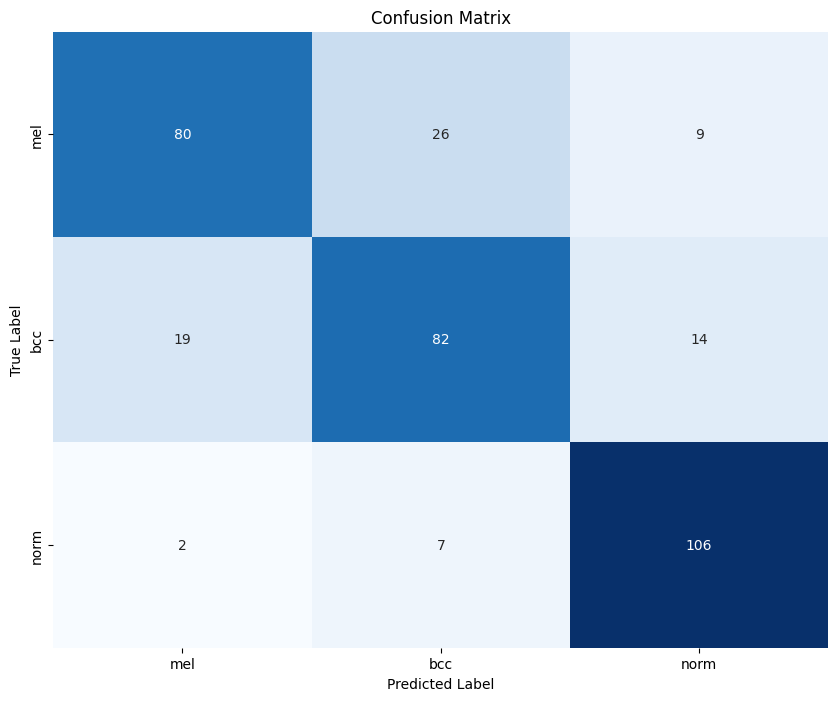

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Menampilkan Confusion Matrix dengan label yang tepat
plt.figure(figsize=(10, 8))
sns.heatmap(best_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

# Mendapatkan nama kelas dari variabel class_names
class_names = ['mel', 'bcc', 'norm']

# Menambahkan label ke sumbu x dan y
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, ha='center')
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, va='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Memuat model SVM terbaik yang sudah disimpan sebelumnya
best_svm = joblib.load('best_svm_model.pkl')

# Parameter yang akan diuji
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Membuat objek GridSearchCV
grid_search = GridSearchCV(estimator=best_svm, param_grid=param_grid, cv=5, scoring='accuracy')

# Melakukan grid search
grid_search.fit(train_features, train_labels)

# Menampilkan parameter terbaik
print("Parameter terbaik:", grid_search.best_params_)


Parameter terbaik: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Best parameters obtained from GridSearchCV
best_params = {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

k = 5  # Number of folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
accuracies = []
precisions = []
sensitivities = []
specificities = []
f1_scores = []
best_accuracy = 0
best_model = None
best_confusion_matrix = None
best_classification_report = None

for fold, (train_index, test_index) in enumerate(skf.split(full_features, full_labels)):
    train_features, test_features = full_features[train_index], full_features[test_index]
    train_labels, test_labels = full_labels[train_index], full_labels[test_index]

    svm = SVC(**best_params)
    svm.fit(train_features, train_labels)

    predictions = svm.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    accuracies.append(accuracy)

    precision = precision_score(test_labels, predictions, average='weighted')
    precisions.append(precision)

    recall = recall_score(test_labels, predictions, average='weighted')
    sensitivities.append(recall)

    cm = confusion_matrix(test_labels, predictions)
    specificity = np.diag(cm) / np.sum(cm, axis=1)
    specificity = np.mean(specificity)
    specificities.append(specificity)

    f1 = f1_score(test_labels, predictions, average='weighted')
    f1_scores.append(f1)

    print(f'Fold {fold + 1}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Sensitivity: {recall:.4f}, Specificity: {specificity:.4f}, F1-score: {f1:.4f}')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = svm
        best_confusion_matrix = cm
        best_classification_report = classification_report(test_labels, predictions)
        joblib.dump(best_model, 'best_svm_model_tuning.pkl')

average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_sensitivity = np.mean(sensitivities)
average_specificity = np.mean(specificities)
average_f1 = np.mean(f1_scores)

print(f'Average accuracy: {average_accuracy:.4f}, Best accuracy: {best_accuracy:.4f}')
print("Best Confusion Matrix:")
print(best_confusion_matrix)
print("Best Classification Report:")
print(best_classification_report)

print(f'Average Precision: {average_precision:.4f}')
print(f'Average Sensitivity: {average_sensitivity:.4f}')
print(f'Average Specificity: {average_specificity:.4f}')
print(f'Average F1-score: {average_f1:.4f}')


Fold 1, Accuracy: 0.8986, Precision: 0.8987, Sensitivity: 0.8986, Specificity: 0.8986, F1-score: 0.8986
Fold 2, Accuracy: 0.8406, Precision: 0.8413, Sensitivity: 0.8406, Specificity: 0.8406, F1-score: 0.8385
Fold 3, Accuracy: 0.8667, Precision: 0.8688, Sensitivity: 0.8667, Specificity: 0.8667, F1-score: 0.8669
Fold 4, Accuracy: 0.8261, Precision: 0.8268, Sensitivity: 0.8261, Specificity: 0.8261, F1-score: 0.8264
Fold 5, Accuracy: 0.8783, Precision: 0.8794, Sensitivity: 0.8783, Specificity: 0.8783, F1-score: 0.8783
Average accuracy: 0.8620, Best accuracy: 0.8986
Best Confusion Matrix:
[[ 99  11   5]
 [  9 104   2]
 [  7   1 107]]
Best Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       115
           1       0.90      0.90      0.90       115
           2       0.94      0.93      0.93       115

    accuracy                           0.90       345
   macro avg       0.90      0.90      0.90       345
weighted 

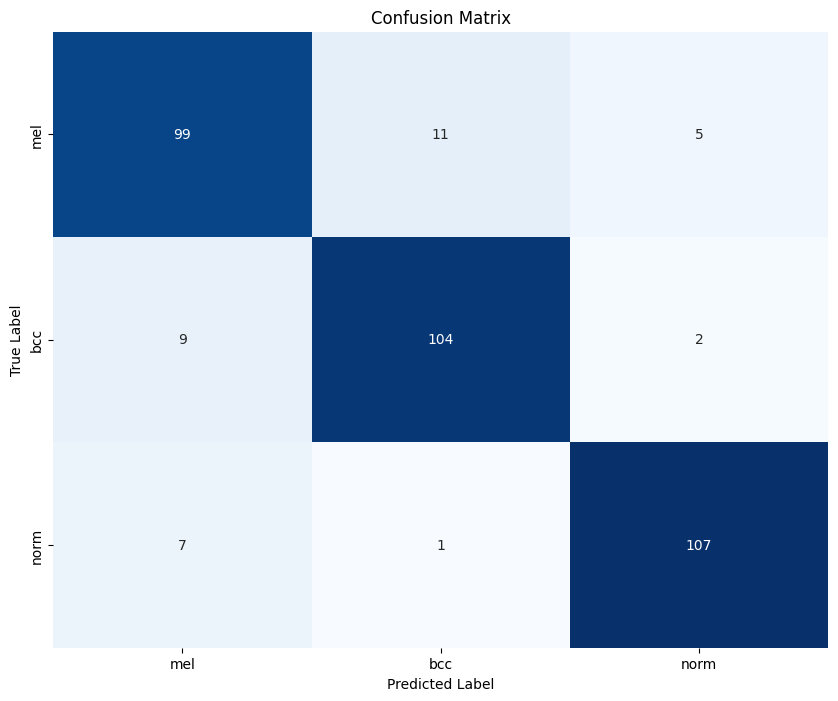

In [ ]:
# Menampilkan Confusion Matrix dengan label yang tepat
plt.figure(figsize=(10, 8))
sns.heatmap(best_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

# Mendapatkan nama kelas dari variabel class_names
class_names = ['mel', 'bcc', 'norm']

# Menambahkan label ke sumbu x dan y
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, ha='center')
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, va='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()